# Qcodes example with Alazar ATS 9360

In [1]:
# import all necessary things
%matplotlib nbagg

import qcodes as qc
import qcodes.instrument.parameter as parameter
import qcodes.instrument_drivers.AlazarTech.ATS9360 as ATSdriver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ats_contr

First lets list all the Alazar boards connected to this machine. In most cases this will probably only be a single one

In [2]:
ATSdriver.AlazarTech_ATS.find_boards()

[{'system_id': 1,
  'board_id': 1,
  'board_kind': 'ATS9360',
  'max_samples': 4294967294,
  'bits_per_sample': 12}]

In [3]:
ats_inst = ATSdriver.AlazarTech_ATS9360(name='Alazar1')

In [4]:
# Print all information about this Alazar card
ats_inst.get_idn()  # or .IDN()

{'firmware': '21.07',
 'model': 'ATS9360',
 'max_samples': 4294967294,
 'bits_per_sample': 12,
 'serial': '970513',
 'vendor': 'AlazarTech',
 'CPLD_version': '25.17',
 'driver_version': '6.0.1',
 'SDK_version': '6.1.2',
 'latest_cal_date': '19-10-18',
 'memory_size': '4294967294',
 'asopc_type': 1729463136,
 'pcie_link_speed': '0.5GB/s',
 'pcie_link_width': '8'}

The Alazar is unusual compared to other instruments as it works together with an acquisition controller. The acquisition controller allows to inject custom routines into the rigid Alazar acquisition protocol. In particular, usually acquisition controllers take care of post processing while the driver takes care of the communication with the card.

At the moment QCoDeS only ships with some very basic acquisition controllers.

Here we use a controller that allows us to perform a demodulation of the acquired signal.

In [5]:
# Instantiate an acquisition controller (In this case we are doing a simple DFT) and 
# provide the name of the QCoDeS Instrument of the alazar card that this controller should control
acquisition_controller = ats_contr.Demodulation_AcquisitionController(name='acquisition_controller', 
                                                                      demodulation_frequency=10e6, 
                                                                      alazar_name='Alazar1')

The parameters on the Alazar card are set in a slightly unusual way. As communicating with the card is slow, and sometimes multiple parameters have to be set with a single "command", we use a context manager that takes care of syncing all the paramters to the card after we set them. Remember to sync parameter values to Alazar card when changing values of those parameters which correspond to Alazar card settings (for example `sample_rate` parameter is a global "setting" for the card, while for example `records_per_buffer` is a parameter of the acquisition process and is set to the card only when performing an acquisition).

In [6]:
with ats_inst.syncing():
    ats_inst.clock_source('INTERNAL_CLOCK')
    ats_inst.sample_rate(1_000_000_000)
    ats_inst.clock_edge('CLOCK_EDGE_RISING')
    ats_inst.decimation(1)
    ats_inst.coupling1('DC')
    ats_inst.coupling2('DC')
    ats_inst.channel_range1(.4)
    ats_inst.channel_range2(.4)
    ats_inst.impedance1(50)
    ats_inst.impedance2(50)
    ats_inst.trigger_operation('TRIG_ENGINE_OP_J')
    ats_inst.trigger_engine1('TRIG_ENGINE_J')
    ats_inst.trigger_source1('EXTERNAL')
    ats_inst.trigger_slope1('TRIG_SLOPE_POSITIVE')
    ats_inst.trigger_level1(160)
    ats_inst.trigger_engine2('TRIG_ENGINE_K')
    ats_inst.trigger_source2('DISABLE')
    ats_inst.trigger_slope2('TRIG_SLOPE_POSITIVE')
    ats_inst.trigger_level2(128)
    ats_inst.external_trigger_coupling('DC')
    ats_inst.external_trigger_range('ETR_2V5')
    ats_inst.trigger_delay(0)
    ats_inst.aux_io_mode('AUX_IN_AUXILIARY') # AUX_IN_TRIGGER_ENABLE for seq mode on
    ats_inst.aux_io_param('NONE') # TRIG_SLOPE_POSITIVE for seq mode on
    
    # Note that we set this parameter to a non-0 value for demonstration purposes - doing so allows
    # to perform an acquisition using just the Alazar card without any additional hardware.
    # Read Alazar SDK manual about `AlazarSetTriggerTimeOut` function for more information.
    ats_inst.timeout_ticks(1)

This following command is specific to this acquisition controller. The kwargs provided here are being forwarded to instrument's `acquire` function (`ats_inst.acquire()`).

This way, it becomes (arguably) easy to change acquisition specific settings from the ipython notebook.

In [7]:
acquisition_controller.update_acquisitionkwargs(#mode='NPT',
                 samples_per_record=1024,
                 records_per_buffer=74,
                 buffers_per_acquisition=1,
                 #channel_selection='AB',
                 #transfer_offset=0,
                 #external_startcapture='ENABLED',
                 #enable_record_headers='DISABLED',
                 #alloc_buffers='DISABLED',
                 #fifo_only_streaming='DISABLED',
                 #interleave_samples='DISABLED',
                 #get_processed_data='DISABLED',
                 allocated_buffers=1,
                 #buffer_timeout=1000
)

Getting the value of the parameter `acquisition` of the instrument `acquisition_controller` performes the entire acquisition protocol. The type/shape/kind of the returned value depends on the specific implementation of the acquisition controller in use. In this particular example, the output will be a single value (see the docstring of `Demodulation_AcquisitionController`).

In [8]:
acquisition_controller.acquisition()

4.3529811704081505

In [9]:
# make a snapshot of the 'ats_inst' instrument
ats_inst.snapshot()

{'functions': {},
 'submodules': {},
 '__class__': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
 'parameters': {'IDN': {'value': None,
   'ts': None,
   'raw_value': None,
   '__class__': 'qcodes.instrument.parameter.Parameter',
   'full_name': 'Alazar1_IDN',
   'inter_delay': 0,
   'name': 'IDN',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
   'instrument_name': 'Alazar1',
   'unit': '',
   'post_delay': 0,
   'label': 'IDN',
   'vals': '<Anything>'},
  'clock_source': {'value': 'INTERNAL_CLOCK',
   'ts': '2019-03-14 17:55:07',
   'raw_value': 1,
   '__class__': 'qcodes.instrument_drivers.AlazarTech.utils.TraceParameter',
   'full_name': 'Alazar1_clock_source',
   'inter_delay': 0,
   'name': 'clock_source',
   'instrument': 'qcodes.instrument_drivers.AlazarTech.ATS9360.AlazarTech_ATS9360',
   'instrument_name': 'Alazar1',
   'val_mapping': {'INTERNAL_CLOCK': 1,
    'FAST_EXTERNAL_CLOCK': 2,
    'EXTERNAL_CLOCK_10MHz_REF': 7

Finally, the following shows that Alazar driver and its acquisition controller work well within a legacy QCoDeS loop.

Started at 2019-03-14 17:55:07
DataSet:
   location = 'data/2019-03-14/#003_AlazarTest_17-55-07'
   <Type>   | <array_id>                         | <array.name> | <array.shape>
   Setpoint | dummy_set                          | dummy        | (50,)
   Measured | acquisition_controller_acquisition | acquisition  | (50,)
Finished at 2019-03-14 17:55:11


<IPython.core.display.Javascript object>


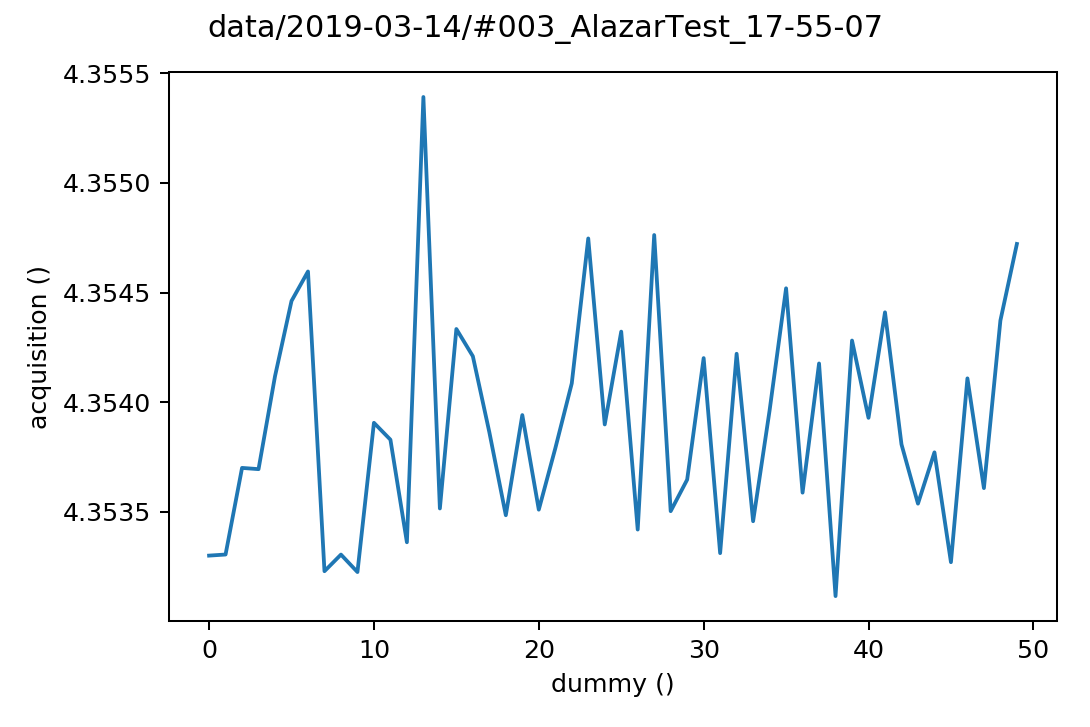

In [10]:
dummy = parameter.ManualParameter(name="dummy")
data = qc.Loop(dummy[0:50:1]).each(acquisition_controller.acquisition).run(name='AlazarTest')
qc.MatPlot(data.acquisition_controller_acquisition)